In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/sequences.zip -d /content/sample_data/sequences

In [5]:
base_path="/content/sample_data/sequences/sequences"
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
from torchvision.transforms import functional as F
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import copy
from tqdm import tqdm
import tqdm.notebook as tq
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
enlarge=2
batch_size=256

In [6]:
def read_data(base_path):
  x=list()
  y=list()
  c=0
  for folder in os.listdir(base_path):    
    if os.path.isdir(base_path+"/"+folder):
      folder_path=base_path+"/"+folder
      labels=list()
      f = open(folder_path+"/groundtruth.txt", "r").readlines()
      ground_truth=list()
      for g_r in f:
        g_rs=list()
        for i in g_r.split("\n")[0].split(","):
          g_rs.append(float(i))        
        ground_truth.append(g_rs)#grs are added for one folder
      frames=os.listdir(folder_path+"/color")
      frames.sort()
      frames=[folder_path+"/color/"+fr for fr in frames]#frames path assigned
      if len(ground_truth[0])==8:
        for i in range(len(frames)-1):
          x.append([frames[i],frames[i+1]])
          y.append(np.array(ground_truth[i]))
          y.append(np.array(ground_truth[i+1]))
          c+=1
  x=np.array(x)
  y=np.array(y).reshape(-1,2,8)

  return x,y

In [7]:
def get_center(bb):
  return (bb[0]+bb[2])/2,  (bb[1]+bb[3])/2

def get_h_w(bb):#returns height weight
  return (bb[2]-bb[0]),  (bb[3]-bb[1])

def get_bb(coord):
  if len(coord)==8:
    left=math.floor(min(coord[0],coord[2],coord[4],coord[6]))
    right=math.ceil(max(coord[0],coord[2],coord[4],coord[6]))
    top=math.floor(min(coord[1],coord[3],coord[5],coord[7]))
    bot=math.ceil(max(coord[1],coord[3],coord[5],coord[7]))
  else:
    left=coord[0]
    top=coord[1]
    right=coord[0]+coord[2]
    bot=coord[1]+coord[3]
  return [left,top,right,bot]  

def scale(img,bb):
  h,w=img.shape[:2]
  bb[0]=bb[0]*2/w
  bb[1]=bb[1]*2/h
  bb[2]=bb[2]*2/w
  bb[3]=bb[3]*2/h

def reverse_scale(img,bb):
  h,w=img.shape[:2]
  bb[0]=bb[0]*w/2
  bb[1]=bb[1]*h/2
  bb[2]=bb[2]*w/2
  bb[3]=bb[3]*h/2

def enlarge_bb(bb):#two times enlarged version
  x,y=get_center(bb)
  bb_new=list()
  bb_new.append(max(0,bb[0]*enlarge-x))
  bb_new.append(max(0,bb[1]*enlarge-y))
  bb_new.append(bb[2]*enlarge-x)
  bb_new.append(bb[3]*enlarge-y)
  return bb_new

def shrink_bb(bb):#return back the enlarged bbox to original
  x,y=get_center(bb)
  bb_new=list()
  bb_new.append((bb[0]+x)/enlarge)
  bb_new.append((bb[1]+y)/enlarge)
  bb_new.append((bb[2]+x)/enlarge)
  bb_new.append((bb[3]+y)/enlarge)
  return bb_new

def cropImg(img,bb):
  bb_new=enlarge_bb(bb)
  if bb_new[3]-bb_new[1]<2:
    bb_new[3]+=3
    bb_new[1]=0 if bb_new[1]<3 else bb_new[1]-3
    
  if bb_new[2]-bb_new[0]<2:
    bb_new[2]+=3
    bb_new[0]=0 if bb_new[0]<3 else bb_new[0]-3
  crop_img=img[:,int(bb_new[1]):int(bb_new[3]),#(3,224,224) to cropped bbox size
               int(bb_new[0]):int(bb_new[2])]
  return crop_img,bb_new

In [8]:
class MyDataset(Dataset):
    def __init__(self, data_paths, ground_truth):
        self.data_paths = data_paths  # Could be a list: [['./train/input/image_1.bmp', './train/input/image_2.bmp'], ...]
        self.labels=ground_truth
        
    def __getitem__(self, index):
        prev = Image.open(self.data_paths[index][0])
        prev = F.to_tensor(prev)
        h=prev.shape[1]/224
        w=prev.shape[2]/224
        prev=F.resize(prev,(224,224))

        curr = Image.open(self.data_paths[index][1])
        curr=F.to_tensor(curr)
        h2=curr.shape[1]/224
        w2=curr.shape[2]/224
        curr=F.resize(curr,(224,224))   
        for j in range(2):
          for i in range(len(self.labels[index][j])):
            if i%2==0:
              self.labels[index][j][i]/=w
            else:
              self.labels[index][j][i]/=h
  #returns (resized images), (resized ground truths), (img paths)
        return (prev,curr),(self.labels[index][0],self.labels[index][1]),(self.data_paths[index][0],self.data_paths[index][1])

    def __len__(self):
        return len(self.data_paths)

In [9]:
x,y=read_data(base_path)
dataset=MyDataset(x,y)
train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True)

In [10]:
n=len(dataset)
test_size=int(0.25*n)#Dataset divided  as 60(train)-20(val)-20(test)
train_size=n-2*test_size
indices=list(range(n))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, val_indices,test_indices = (indices[:train_size]
      ,indices[train_size:train_size+test_size]
                          , indices[train_size+test_size:])

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_set_loader=torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler,drop_last=True)

val_set_loader=torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=valid_sampler,drop_last=True)

test_set_loader=torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=test_sampler,drop_last=True)

In [11]:
for b,l,p in train_loader:
  print(type(b[0]),type(l[0]),type(p))
  print(p[0])
  print(len(p[0]))
  break
for b,l,p in test_set_loader:
  print(type(b[0]),type(l[0]),type(p))
  print(p[0])
  print(len(p[0]))
  break

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'list'>
('/content/sample_data/sequences/sequences/gymnastics2/color/00000101.jpg', '/content/sample_data/sequences/sequences/wiper/color/00000283.jpg', '/content/sample_data/sequences/sequences/singer2/color/00000298.jpg', '/content/sample_data/sequences/sequences/iceskater2/color/00000124.jpg', '/content/sample_data/sequences/sequences/girl/color/00000593.jpg', '/content/sample_data/sequences/sequences/car1/color/00000047.jpg', '/content/sample_data/sequences/sequences/book/color/00000055.jpg', '/content/sample_data/sequences/sequences/crossing/color/00000102.jpg', '/content/sample_data/sequences/sequences/graduate/color/00000744.jpg', '/content/sample_data/sequences/sequences/bag/color/00000157.jpg', '/content/sample_data/sequences/sequences/iceskater1/color/00000002.jpg', '/content/sample_data/sequences/sequences/blanket/color/00000124.jpg', '/content/sample_data/sequences/sequences/iceskater2/color/00000558.jpg', '/content/sampl

In [13]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        model = models.resnet18(pretrained=True)
        self.convnet = nn.Sequential(*list(model.children())[:-1])
        self.convnet = self.convnet.cuda() if device else net
        for param in self.convnet.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
                nn.Linear(1024, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4),#four bbox outputs are set
                )
        self.classifier = self.classifier.cuda() if device else net

    def forward(self, x, y):
        x1 = self.convnet(x)
        x1 = x1.view(x.size(0), -1)
        x2 = self.convnet(y)
        x2 = x2.view(x.size(0), -1)
        x = torch.cat((x1, x2), 1)#two images are concatenated.
        x = self.classifier(x)
        return x

In [14]:
def train_model(model, criterion, optimizer, scheduler,
                dataset,num_epochs=7,is_train=True):
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss=150
  lost_list=list()
  for epoch in range(num_epochs):
    if is_train:
      model.train()
    else:
      model.eval() 
    running_loss = 0.0
    for local_batch, local_labels,local_paths in tq.tqdm(dataset):
      local_batch[0]=local_batch[0].to(device)#prev img
      local_batch[1]=local_batch[1].to(device)#curr img
      local_labels[0]=local_labels[0].to(device)#prev g_t
      local_labels[1]=local_labels[1].to(device)#curr g_t

      bb_list=list()
      for i in range(len(local_labels[0])): #image cropping was handled this loop
        prev_gt=local_labels[0][i]#prev ground truth
        curr_gt=local_labels[1][i]#curr ground truth    
        bb=get_bb(prev_gt)
        if epoch==0:#crop the img only at the first epoch
          crop_img,bb_new=cropImg(local_batch[0][i],bb)
          crop_img=F.resize(crop_img,(224,224))
          local_batch[0][i]=crop_img#change 

        bb2=get_bb(curr_gt)
        bb_list.append(bb2)   
        if epoch==0:#crop the img only at the first epoch
          crop_img2,bb_new2=cropImg(local_batch[1][i],bb)
          crop_img2=F.resize(crop_img2,(224,224))
          local_batch[1][i]=crop_img2
      
      bb_list=torch.Tensor(bb_list)/224.
      bb_list=bb_list.to(device)

      optimizer.zero_grad()

      with torch.set_grad_enabled(is_train):
        outputs = model(local_batch[0],local_batch[1])     #features extracted   
        outputs=(outputs/2+0.5)
        loss = criterion(outputs, bb_list)
        # backward + optimize only if in training phase
        if is_train:
            loss.backward()
            optimizer.step()
            
      running_loss += loss.item() * local_batch[0].size(0)
    if is_train:#decrease learning rate and so on
      scheduler.step()

    epoch_loss = running_loss / len(dataset.dataset)
    lost_list.append(epoch_loss)
    print('Loss: {:.4f} Epoch {}'.format(epoch_loss,epoch))

    # deep copy the model
    if is_train==False and best_loss>epoch_loss:
        best_loss=epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
  
  model.load_state_dict(best_model_wts)#when validation occurs best model is assign
  return model,lost_list

In [15]:
xx_net=MyNet()
loss=nn.MSELoss()
loss.to(device)
tr_loader=train_set_loader
optimizer = optim.SGD(xx_net.classifier.parameters(),
                          lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, 
                                      step_size=7, gamma=0.1)

model_ft,tr_lost_list=train_model(xx_net,loss,optimizer,scheduler,train_set_loader,num_epochs=7)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Loss: 0.0198 Epoch 0



Loss: 0.0414 Epoch 1



Loss: 0.0441 Epoch 2



Loss: 0.0364 Epoch 3



Loss: 0.0307 Epoch 4



Loss: 0.0305 Epoch 5



Loss: 0.0368 Epoch 6


In [16]:
model_ft2,val_lost_list=train_model(xx_net,loss,optimizer,scheduler,
                     val_set_loader,num_epochs=7,is_train=False)#do the validation with the model


Loss: 0.0096 Epoch 0



Loss: 0.0261 Epoch 1



Loss: 0.0417 Epoch 2



Loss: 0.0503 Epoch 3



Loss: 0.0556 Epoch 4



Loss: 0.0601 Epoch 5



Loss: 0.0653 Epoch 6


In [ ]:
model_ft,lost_list=train_model(model_ft,loss,optimizer,scheduler,
    train_set_loader,num_epochs=1,is_train=False)#epoch is set to 1 only show the evalution output


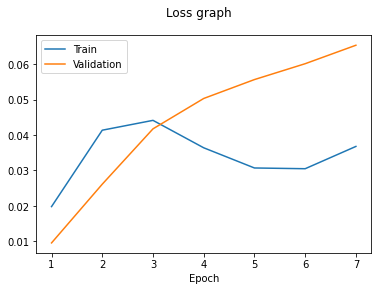

In [51]:
def plotting(x, y, y2, label1="Train", label2="Loss",
             xlabel="Epoch", ylabel="Accuracy", title="title"):
    fig, (ax1) = plt.subplots(1, 1)
    fig.suptitle(title)
    ax1.plot(x, y, label=label1)
    ax1.plot(x,y2,label="Validation")

    ax1.set_xlabel(xlabel)
    ax1.legend()
    plt.show()

plotting(list(range(1,8)),tr_lost_list,val_lost_list,title="Loss graph")

In [52]:
print((result_s[0])*224.,(j[0][1]))
plt.imshow(i[0][0][1].cpu())
#[  17.2169,  355.3003,   20.3675,  466.5350,   17.1094, 1782.5860,          13.9588, 1671.3815]
a,b,c,d=get_bb([  2.6566,  56.3656,   3.1713,  73.2914,   2.6952, 279.7621,   2.1805,        262.8382])
print(a,b,c,d)
rect = patches.Rectangle((a, b), c, d, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(rect)
plt.show()

NameError: ignored

torch.Size([3, 224, 224])

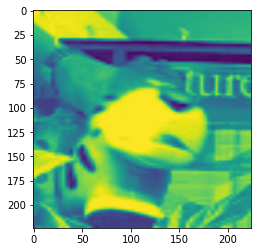

In [ ]:
plt.imshow(crop_img[1].cpu())
crop_img.shape

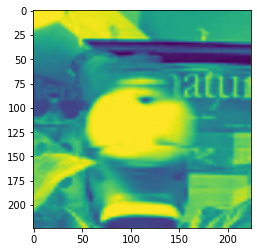

In [ ]:
plt.imshow(crop_img2[1].cpu())

<function cropImg at 0x7f67089935f0>
(167, 138, 3) (432, 576, 3)


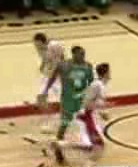

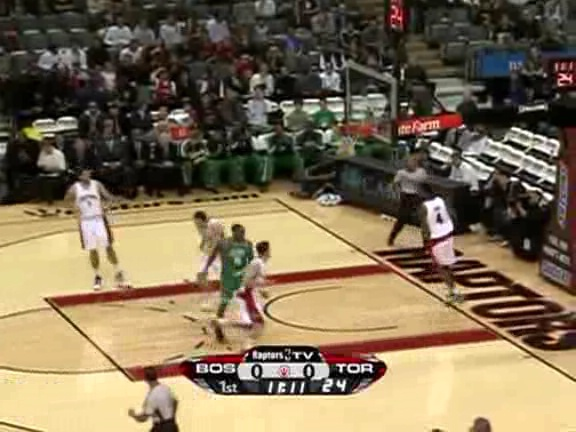

In [ ]:
q=153


In [ ]:
summary(net,(3,224,5))

In [ ]:
summary(resnet,(3,224,5))

In [ ]:
c=0
for local_batch, local_labels in tqdm(train_loader):

  local_batch[0]=local_batch[0].to(device)#prev img
  local_batch[1]=local_batch[1].to(device)#curr img
  local_labels[0]=local_labels[0].to(device)#prev g_t
  local_labels[1]=local_labels[1].to(device)#curr g_t
  
  for i in range(batch_size):
    prev_gt=local_labels[0][i]#prev ground truth
    curr_gt=local_labels[1][i]#curr ground truth    
    bb=get_bb(prev_gt)
    crop_img,bb_new=cropImg(local_batch[0][i],bb)
    crop_img=F.resize(crop_img,(224,224))
    local_batch[0][i]=crop_img#change 

    bb2=get_bb(curr_gt)   
    crop_img2,bb_new2=cropImg(local_batch[1][i],bb)
    crop_img2=F.resize(crop_img2,(224,224))
    local_batch[1][i]=crop_img2
    
    print(bb,bb_new,bb2,bb_new2) 

  #local_labels[0] first batch of two
  #local_labels[0][0] first prev in first batch

  #plt.imshow(local_batch[0][0][0].cpu())
  #print(local_batch[0][0].size())

  
  break
